# SKIN DISEASE PREDICTION
## Architect : Resnet50
## Dataset : HAM10000

In [1]:
%matplotlib inline     
!pip install "torch==1.4" "torchvision==0.5 " # To avoid warning error for each and every image in the dataset 

     |████████████████████████████████| 753.4MB 21kB/s 
     |████████████████████████████████| 4.0MB 26.4MB/s 
  Found existing installation: torch 1.5.0+cu101
    Uninstalling torch-1.5.0+cu101:
      Successfully uninstalled torch-1.5.0+cu101
  Found existing installation: torchvision 0.6.0+cu101
    Uninstalling torchvision-0.6.0+cu101:
      Successfully uninstalled torchvision-0.6.0+cu101


### Importing the necessary packages

In [2]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *

import os
import io
import tarfile
import numpy as np
import PIL
import seaborn as sns




/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Kaggle API, which is used to download the dataset from kaggle directly to colab 

In [0]:
os.environ['KAGGLE_USERNAME'] = "anjana22"
os.environ['KAGGLE_KEY'] = "16acf05db0477eb1236698f72ea68121"

### Downloading the  dataset from kaggle 

In [4]:
!kaggle datasets download -d tsaideepak/skincancer

100% 462M/462M [00:04<00:00, 127MB/s]



### unziping the downloaded zip file

In [5]:
!unzip skincancer.zip

Streaming output truncated to the last 5000 lines.
  inflating: datatree/train/nv/ISIC_0029904.jpg  
  inflating: datatree/train/nv/ISIC_0029905.jpg  
  inflating: datatree/train/nv/ISIC_0029906.jpg  
  inflating: datatree/train/nv/ISIC_0029907.jpg  
  inflating: datatree/train/nv/ISIC_0029908.jpg  
  inflating: datatree/train/nv/ISIC_0029910.jpg  
  inflating: datatree/train/nv/ISIC_0029911.jpg  
  inflating: datatree/train/nv/ISIC_0029916.jpg  
  inflating: datatree/train/nv/ISIC_0029918.jpg  
  inflating: datatree/train/nv/ISIC_0029920.jpg  
  inflating: datatree/train/nv/ISIC_0029921.jpg  
  inflating: datatree/train/nv/ISIC_0029922.jpg  
  inflating: datatree/train/nv/ISIC_0029923.jpg  
  inflating: datatree/train/nv/ISIC_0029925.jpg  
  inflating: datatree/train/nv/ISIC_0029926.jpg  
  inflating: datatree/train/nv/ISIC_0029928.jpg  
  inflating: datatree/train/nv/ISIC_0029934.jpg  
  inflating: datatree/train/nv/ISIC_0029935.jpg  
  inflating: datatree/train/nv/ISIC_0029936.jpg  

In [0]:
sPath = Path("/content/datatree/train")

### No of classes in the dataset 

In [7]:
classes = os.listdir("/content/datatree/train")
print(classes)

['df', 'vasc', 'bcc', 'akiec', 'nv', 'mel', 'bkl']


### Checks ofr nana values in the dataset and deletes it 

In [8]:
for c in classes:
  verify_images(sPath/c, delete = True, max_workers=16)

### Splitting train and validation set

In [0]:
np.random.seed(8)
src = (ImageList.from_folder(sPath)
  .split_by_rand_pct(valid_pct = 0.2)
  .label_from_folder())

### Data Augumentation 

In [0]:
tfdm = get_transforms(max_rotate = 25, max_zoom = 1.3, max_warp = 0.4)

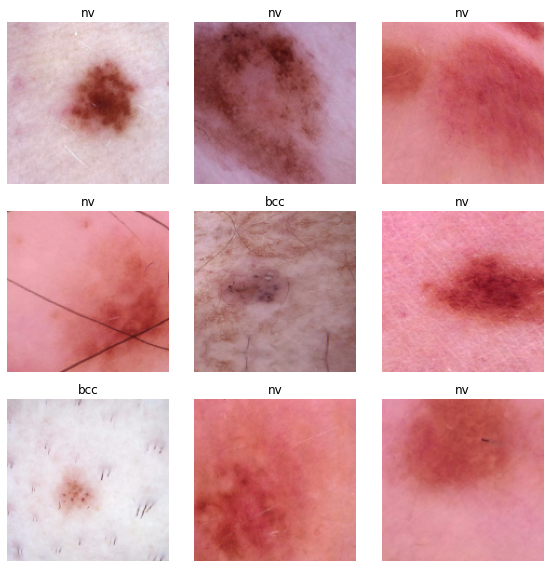

In [11]:
  data = (src.transform(tfdm,size = 150)
    .databunch(bs = 124) # initializing the batch size
    .normalize(imagenet_stats))# normalizing 
  data.show_batch(rows = 3, figsize = (8,8))

### Downloading a Pre-trained model 

In [12]:
learner50 = cnn_learner(data, models.resnet50, metrics = accuracy)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


### A trail run to find the most appropriate learning rate

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


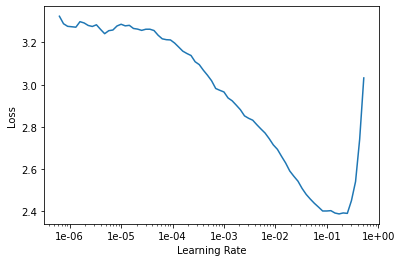

In [13]:
learner50.lr_find()
learner50.recorder.plot()

In [0]:
lr = 1e-03

### Training starts 

In [21]:
learner50.fit_one_cycle(10, max_lr =slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,0.543446,0.530122,0.804375,02:15
1,0.536470,0.540032,0.799375,02:15
2,0.541604,0.563990,0.795000,02:15
3,0.535845,0.538831,0.800625,02:15
4,0.526672,0.521318,0.805000,02:15
5,0.509579,0.497913,0.810625,02:15
6,0.484405,0.489866,0.811250,02:15
7,0.462789,0.478254,0.805625,02:17
8,0.460038,0.469648,0.807500,02:17
9,0.437948,0.470947,0.811250,02:18


### Acuracy on a pre-trained model is 81%

### Loss analyzing 

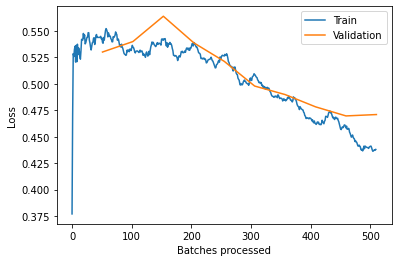

In [23]:
learner50.recorder.plot_losses()

In [0]:
learner50.save('resenet50-prototype1')

In [25]:
interp = ClassificationInterpretation.from_learner(learner50)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)


True

### Visualizing the wrongly predicted images

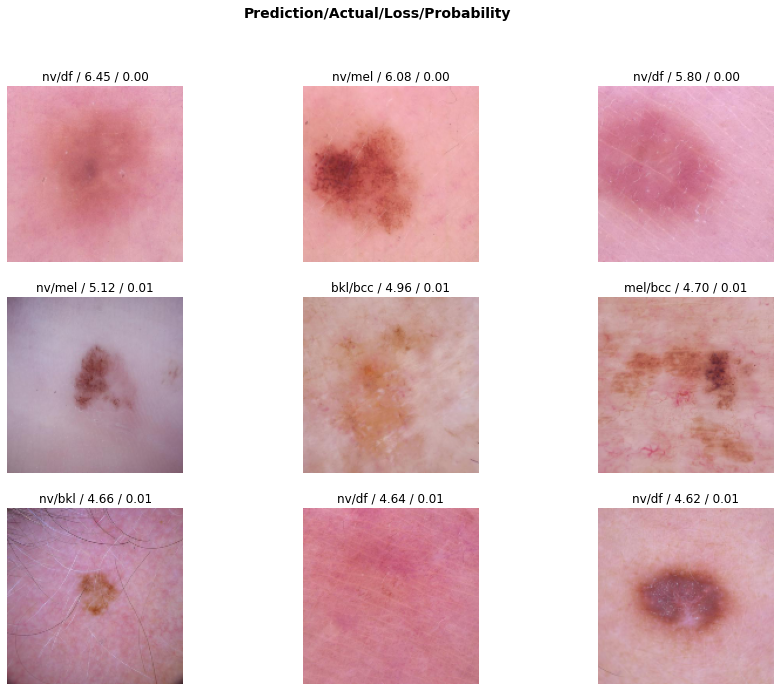

In [26]:
interp.plot_top_losses(9, figsize=(15,11))

### Visualization of the algorithm's performance

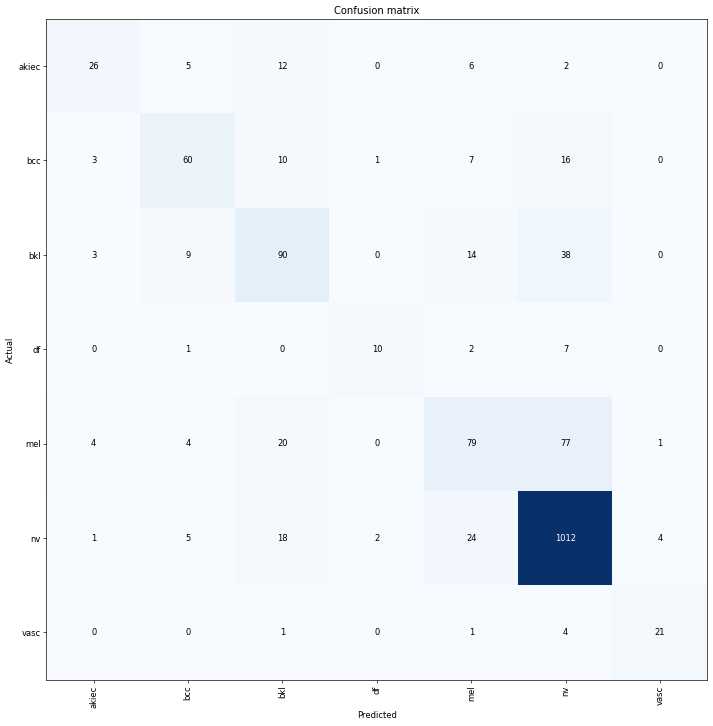

In [28]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)


### List of Confused classes

In [29]:
interp.most_confused(min_val=2)


[('mel', 'nv', 77),
 ('bkl', 'nv', 38),
 ('nv', 'mel', 24),
 ('mel', 'bkl', 20),
 ('nv', 'bkl', 18),
 ('bcc', 'nv', 16),
 ('bkl', 'mel', 14),
 ('akiec', 'bkl', 12),
 ('bcc', 'bkl', 10),
 ('bkl', 'bcc', 9),
 ('bcc', 'mel', 7),
 ('df', 'nv', 7),
 ('akiec', 'mel', 6),
 ('akiec', 'bcc', 5),
 ('nv', 'bcc', 5),
 ('mel', 'akiec', 4),
 ('mel', 'bcc', 4),
 ('nv', 'vasc', 4),
 ('vasc', 'nv', 4),
 ('bcc', 'akiec', 3),
 ('bkl', 'akiec', 3),
 ('akiec', 'nv', 2),
 ('df', 'mel', 2),
 ('nv', 'df', 2)]

### Unfreezing the layers of the pre-trained model to get trained on our dataset 

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


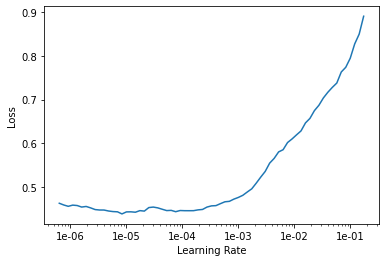

In [30]:
learner50.unfreeze()
learner50.lr_find() # To find the most appropriate learning rate
learner50.recorder.plot()

### Training the entire layers of the architecture

In [0]:
learner50.fit_one_cycle(3, max_lr = slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy,time
0,0.494684,0.505473,0.829375,02:14
1,0.504470,0.491632,0.826875,02:15
2,0.461326,0.480593,0.832500,02:15


### Accuracy on the Transfer-learning model is 83%

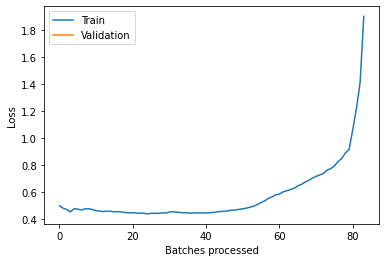

In [31]:
learner50.recorder.plot_losses() #loss visualization


In [32]:

interp = ClassificationInterpretation.from_learner(learner50)


In [33]:
interp.most_confused(min_val=1) #list of wrongly predicted classes 


[('mel', 'nv', 77),
 ('bkl', 'nv', 38),
 ('nv', 'mel', 24),
 ('mel', 'bkl', 20),
 ('nv', 'bkl', 18),
 ('bcc', 'nv', 16),
 ('bkl', 'mel', 14),
 ('akiec', 'bkl', 12),
 ('bcc', 'bkl', 10),
 ('bkl', 'bcc', 9),
 ('bcc', 'mel', 7),
 ('df', 'nv', 7),
 ('akiec', 'mel', 6),
 ('akiec', 'bcc', 5),
 ('nv', 'bcc', 5),
 ('mel', 'akiec', 4),
 ('mel', 'bcc', 4),
 ('nv', 'vasc', 4),
 ('vasc', 'nv', 4),
 ('bcc', 'akiec', 3),
 ('bkl', 'akiec', 3),
 ('akiec', 'nv', 2),
 ('df', 'mel', 2),
 ('nv', 'df', 2),
 ('bcc', 'df', 1),
 ('df', 'bcc', 1),
 ('mel', 'vasc', 1),
 ('nv', 'akiec', 1),
 ('vasc', 'bkl', 1),
 ('vasc', 'mel', 1)]

### Prediction over the test data

In [0]:
test_path = '/content/datatree/validation/'


In [0]:
test_Data = (ImageList.from_folder(test_path)
       .split_by_rand_pct(valid_pct=0.2)
       .label_from_folder()
       .transform(size=150)
       .databunch(bs=64))


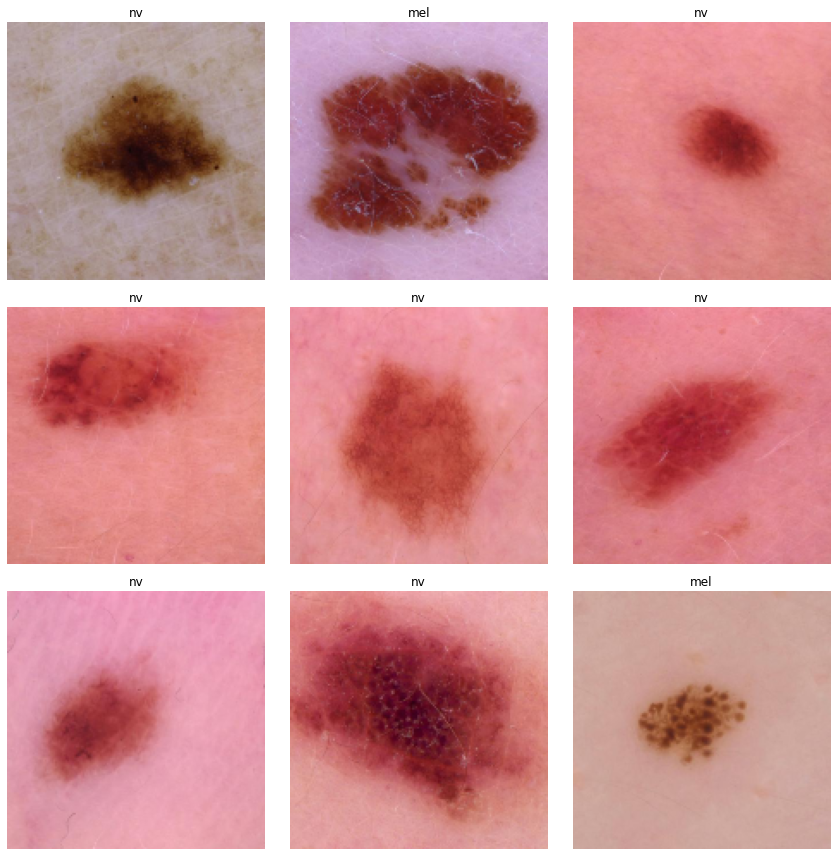

In [36]:
test_Data.show_batch(rows=3)


In [37]:
pred, y = learner50.get_preds()


In [38]:
pred

tensor([[8.9712e-04, 3.9447e-04, 1.8897e-02,  ..., 6.3116e-04, 9.7761e-01,
         8.2122e-05],
        [6.4514e-04, 3.5674e-04, 4.7529e-01,  ..., 1.1765e-02, 5.1181e-01,
         6.8449e-05],
        [3.1080e-01, 3.2298e-01, 1.2930e-01,  ..., 1.4691e-01, 1.3054e-03,
         6.3520e-03],
        ...,
        [8.2781e-04, 2.5765e-04, 2.4983e-02,  ..., 5.1230e-01, 4.6078e-01,
         8.0653e-04],
        [5.8429e-06, 2.7579e-06, 1.1061e-04,  ..., 2.5287e-04, 9.9962e-01,
         5.0056e-06],
        [8.3429e-05, 1.0888e-03, 4.6292e-01,  ..., 1.7000e-01, 3.6519e-01,
         4.8259e-04]])

In [39]:
y

tensor([5, 2, 2,  ..., 4, 5, 2])

In [0]:
pred = pred.argmax(dim = 1)

In [41]:
pred

tensor([5, 5, 1,  ..., 4, 5, 2])

### Different classes available under the test folder

In [42]:
test_Data.classes

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

In [43]:
from sklearn.metrics import classification_report

print(classification_report(y, pred))


              precision    recall  f1-score   support

           0       0.70      0.51      0.59        51
           1       0.71      0.62      0.66        97
           2       0.60      0.58      0.59       154
           3       0.77      0.50      0.61        20
           4       0.59      0.43      0.50       185
           5       0.88      0.95      0.91      1066
           6       0.81      0.78      0.79        27

    accuracy                           0.81      1600
   macro avg       0.72      0.62      0.66      1600
weighted avg       0.80      0.81      0.80      1600



### model fo web app

In [0]:
learner50.export()

In [0]:
defaults.device = torch.device('cpu')

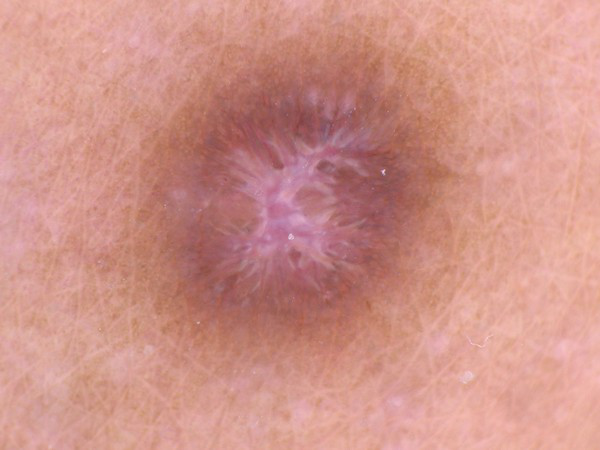

In [51]:
img = open_image("/content/1_R6N4Bi2slLO0p59g41dCcQ.jpeg")
img

In [0]:
learner50 = load_learner(sPath)

In [53]:
pred_class,pred_idx,outputs = learner50.predict(img)
pred_class

Category tensor(3)